# <h3>Dependencies</h3>

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline  
import matplotlib.pyplot as plt

from dask import dataframe as dd
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import keras
from keras import *
import keras.backend as K
from keras.layers import Embedding, Input,concatenate, Flatten,dot, Dense
from keras.models import Model
from keras.optimizers import Adam

# <h1>Training Set Prep </h1>

In [2]:
#download data here: https://github.com/hexiangnan/neural_collaborative_filtering/tree/master/Data
pos_train=pd.read_csv('/media/jma/DATA/neural_collaborative_filtering-master/Data/pinterest-20.train.rating',sep="\t", names=['userID', 'itemID','rating','timestamp' ])
pos_train = pos_train.drop (['timestamp','rating'], axis=1)
print(pos_train.shape)
pos_train.head()


(1445622, 2)


,userID,itemID
0,0,2
1,0,3
2,0,4
3,0,5
4,0,6


<h3>Unique Users</h3>

In [3]:
unique_items=pos_train.itemID.unique() #these are unique items
print('Unique items: '+str(len(unique_items)))

unique_users=pos_train.userID.unique() #these are unique items
print('Unique users: '+str(len(unique_users)))


Unique items: 9911
Unique users: 55187


In [ ]:
'''
Map each user and item ID to a distinct contiguous integer
Create dictionary of this mapping
Add a "catch-all" for other IDs not seen

'''

In [6]:
#clean up the users and items to make sure they are contiguous.

user_code_dict ={j:i for (i,j) in  enumerate(np.sort(unique_users))}
user_decode_dict ={i:j for (i,j) in  enumerate(np.sort(unique_users))}

item_code_dict ={j:i for (i,j) in  enumerate(np.sort(unique_items))}
item_decode_dict ={i:j for (i,j) in  enumerate(np.sort(unique_items))}

pos_train_coded= pos_train.values


for i,_ in enumerate(pos_train.values):
    pos_train_coded[i,0]=user_code_dict[int(pos_train.values[i,0])]
    pos_train_coded[i,1]=item_code_dict[int(pos_train.values[i,1])]

    
    
#add catch alls (next numeric key and length of uniques as values start with zero)
print(max(user_code_dict.keys()))
print(max(item_code_dict.keys()))
user_code_dict[max(user_code_dict.keys())+1]=len(user_code_dict)
item_code_dict[max(item_code_dict.keys())+1]=len(item_code_dict)

#as DF to use as lookup of test sets
user_df=pd.DataFrame(np.column_stack([list(user_code_dict.keys()),list(user_code_dict.values())]),columns=['key','value'])
item_df=pd.DataFrame(np.column_stack([list(item_code_dict.keys()),list(item_code_dict.values())]),columns=['key','value'])


55186
9915


<h3>Distribution of positive events per User</h3>

count    55187.000000
mean        26.194973
std          7.527052
min         14.000000
25%         21.000000
50%         24.000000
75%         29.000000
max        136.000000
Name: userID, dtype: float64

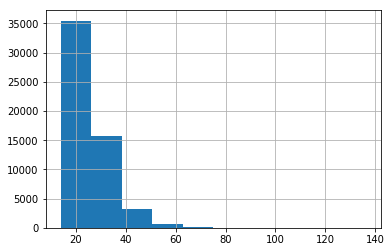

In [6]:
user_gp=pos_train['userID'].value_counts()


user_gp.hist()
user_gp.describe()


# <h1>Test Set Prep</h1>

In [ ]:
'''
Clean up test set from sparse matrix format
Encode IDs with the mapping of training set above
Stack positive example and 99 negative examples


'''

In [7]:
#create test set
neg_test=pd.read_csv('/media/jma/DATA/neural_collaborative_filtering-master/Data/pinterest-20.test.negative',sep="\t", names=['var1']+['neg_item_'+str(i) for i in np.arange(99)+1])
neg_test['user_id'] = neg_test.var1.str.extract(r'([0-9]+)(?=,)', expand=False)
neg_test['item_id'] = neg_test.var1.str.extract(r'(?<=,)([0-9]+)', expand=False)                                                                         
      
print(neg_test.shape)



test_coded= np.zeros((neg_test.shape[0],3))

#positives
test_coded[:,0]=neg_test.values[:,100].astype("int")
test_coded[:,1]=neg_test.values[:,101].astype("int")
test_coded[:,2]=np.repeat(1,neg_test.shape[0])

pos_examples=pd.DataFrame(test_coded,columns=['user','item','respond'])

print(pos_examples.shape)

#col index 1-99 are items
#user is 100
t=neg_test.iloc[:,1:101]
neg_examples=pd.melt(t,id_vars=['user_id'],var_name='iter', value_name='item')
neg_examples['respond']=0
neg_examples=neg_examples[['user_id','item','respond']]
neg_examples.columns.values[0] = 'user' 

test_coded = pd.concat([pos_examples,neg_examples],axis=0)
test_coded=test_coded.astype(int)

print(test_coded.shape)
print(test_coded.dtypes)
  
test_coded.to_csv('/home/jma/Desktop/march_embedding/test_coded.csv',  index=False)



del test_coded

(55187, 102)
(55187, 3)
(5518700, 3)
user       int64
item       int64
respond    int64
dtype: object


In [8]:
#join to update user and items with lookups for how we coded user and item IDS
test_set = pd.read_csv('/home/jma/Desktop/march_embedding/test_coded.csv',dtype='int64')

#update user
test_set=pd.merge(test_set,user_df,  how='left', left_on=['user'],right_on=['key'])
test_set=test_set[['value','item','respond']]
test_set.rename(columns={"value": "user"},inplace=True)
print(test_set[test_set.user==0].head())

#update item
test_set=pd.merge(test_set,item_df,  how='left', left_on=['item'],right_on=['key'])
test_set=test_set[['user','value','respond']]
test_set.rename(columns={"value": "item"},inplace=True)
print(test_set[test_set.user==0].head())

#code missing with out default values
test_set['user']=test_set.user.fillna(55186+1)
test_set['item']=test_set.item.fillna(9915+1)

print(test_set[test_set.user==0].head())

pd.DataFrame(test_set,columns=['user','item','respond']).to_csv('/home/jma/Desktop/march_embedding/test_coded_final.csv',  index=False)

del test_set


        user  item  respond
0          0     1        1
55187      0  2670        0
110374     0  8388        0
165561     0  5861        0
220748     0  5089        0
        user    item  respond
0          0     1.0        1
55187      0  2670.0        0
110374     0  8387.0        0
165561     0  5861.0        0
220748     0  5089.0        0
        user    item  respond
0          0     1.0        1
55187      0  2670.0        0
110374     0  8387.0        0
165561     0  5861.0        0
220748     0  5089.0        0


# <h1>Negative Sampling Generator</h1>

In [ ]:
'''
This function will randomly sample a positive and num_neg exaples from that same user for negatives. 

Too expensive to check on negatives, we will assume it will be rare to sample a positive as a negative


Need to return X as shape (batch_size,[user, input])

'''

In [4]:
#build generator for negative sampling training


def generator_neg_sampling(pos_data,unique_items,num_neg=4, batch_size=128, shuffle =False):
    
    #persist
    i=0
    nb_pos_records = pos_data.shape[0]
    np.random.shuffle(pos_data)
    
    while 1:
        
        #reset each time
        hold_user=[]
        hold_item =[]
        hold_label=[]
        
        
        #number of users to sample with num_neg +1 instances
        n_pos_users = batch_size // (num_neg +1) #on average each bacth will contain this many users
        #extra negatives to sample to meet batch size
        extra_negs = (batch_size - (n_pos_users*(num_neg+1)))
        
        if shuffle: #randomly grab positives
            #sample positive user indexes
            pos_indices=np.random.randint(0, nb_pos_records , n_pos_users)
        
        else: #step through data to grab positives
            
            pos_indices=[]
           
            for indx in range(n_pos_users):
                
                if  i > nb_pos_records -1: #past the end of data, reset
                    i=0
                pos_indices.append(i)
                i+=1

        for user_idx in pos_indices:
            
            #add positives
            hold_user.append(pos_data[user_idx,0])
            hold_item.append(pos_data[user_idx,1])
            hold_label.append(1)
            
            #add random "negatives"
            for cntr in range(num_neg):
                hold_user.append(pos_data[user_idx,0])
                hold_item.append(unique_items[np.random.randint(0,len(unique_items))])
                hold_label.append(0)
        
        #fill in mini batch
        for cntr in range(extra_negs):
                hold_user.append(pos_data[np.random.randint(0,nb_pos_records),0])
                hold_item.append(unique_items[np.random.randint(0,len(unique_items))])
                hold_label.append(0)
    
                
            
        X= [np.array(hold_user),np.array(hold_item)]
        y =np.array(hold_label)
            
            
 
        yield(X, y)
    

# <h1>Train Model</h1>

In [7]:
#train generator
batch_size = 256  #NN batch size
num_neg=4 #number of neg samples for each positive

train_gen=generator_neg_sampling(pos_data=pos_train_coded,unique_items=unique_items,num_neg=num_neg, batch_size=batch_size, shuffle =True)


In [ ]:
'''
Model concatenates user and item embedding vectors (each with dand
feeds them through 3 dense layers of size (32,16,8)
Relu activations with sigmpid for the last layer

'''

In [8]:
#build NN

def get_model(num_users, num_items, embed_dim=50, num_layer=1, layers=[10]):
    
    
    num_layer = len(layers) #Number of layers in the MLP
    
    
    # Input variables
    userIDs = Input(shape=[1])
    itemIDs = Input(shape=[1])
    
    # Embedding layer

    embedding_User = Embedding(input_dim = len(user_code_dict), output_dim = embed_dim, input_length=1)
    embedding_Item = Embedding(input_dim = len(item_code_dict), output_dim = embed_dim, input_length=1)   
    
    
    embedding_User = embedding_User (userIDs)
    embedding_Item = embedding_Item (itemIDs)

    x= concatenate([embedding_User,embedding_Item])
    x=Flatten()(x)
   

    for idx in range(0, num_layer):
        layer = Dense(layers[idx], activation='relu')
        x = layer(x)

    
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform')(x)
    
    model = Model(inputs=[userIDs, itemIDs], outputs=prediction)
    
    return model


In [9]:
model=get_model(num_users=len(unique_users), num_items=len(unique_items), embed_dim=32, num_layer=3, layers=[32,16,8])
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 32)        1766016     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 32)        317184      input_2[0][0]                    
__________________________________________________________________________________________________
concatenat

In [10]:
steps_per_epoch = pos_train.shape[0] // (batch_size // (num_neg +1))  #calculates how many bacthes from the generate constitutes 1 full epoch

hist=model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1)

Epoch 1/10
28345/28345 [==============================] - 132s 5ms/step - loss: 0.3166
Epoch 2/10
28345/28345 [==============================] - 131s 5ms/step - loss: 0.2162
Epoch 3/10
28345/28345 [==============================] - 129s 5ms/step - loss: 0.1946
Epoch 4/10
28345/28345 [==============================] - 128s 5ms/step - loss: 0.1842
Epoch 5/10
28345/28345 [==============================] - 130s 5ms/step - loss: 0.1770
Epoch 6/10
28345/28345 [==============================] - 133s 5ms/step - loss: 0.1720
Epoch 7/10
28345/28345 [==============================] - 129s 5ms/step - loss: 0.1684
Epoch 8/10
28345/28345 [==============================] - 133s 5ms/step - loss: 0.1653
Epoch 9/10
28345/28345 [==============================] - 135s 5ms/step - loss: 0.1625
Epoch 10/10
28345/28345 [==============================] - 137s 5ms/step - loss: 0.1604


In [11]:
#save model
model.save('/home/jma/Desktop/march_embedding/embedding_model.h5')

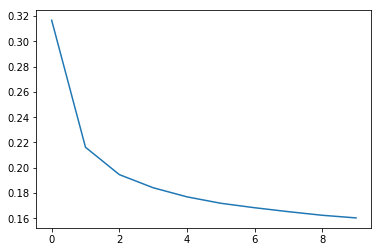

In [12]:
plt.plot(hist.history['loss'])

# <h1>Examine Learned Vectors</h1>

In [21]:
#load model
model=keras.models.load_model('/home/jma/Desktop/march_embedding/embedding_model.h5')


print ('Recall: \nUnique items: 9911\nUnique users: 55187\n\n')

weights=model.get_weights()
print('Size of User Embedding Matrix',weights[0].shape)
print('Size of Item Embedding Matrix',weights[1].shape)

print('\nThe embedding vector learned for user 0:::\n')
print('Size of this vector: ',weights[0][0,:].shape )
weights[0][0,:]

Recall: 
Unique items: 9911
Unique users: 55187


Size of User Embedding Matrix (55188, 32)
Size of Item Embedding Matrix (9912, 32)

The embedding vector learned for user 0:::

Size of this vector:  (32,)


array([ 0.41143423,  0.18503964, -0.06315383,  0.6700903 , -0.8432784 ,
        0.25440395,  0.24474768,  0.36077878,  0.6298261 ,  0.621534  ,
        0.6079664 ,  0.5611511 ,  0.7825801 , -0.21765196, -0.3598696 ,
       -0.2571831 ,  0.5210942 , -0.17665927, -0.49372506,  0.5476562 ,
        0.78053933,  0.31078222, -0.683741  , -1.0129145 ,  0.4008244 ,
        0.21178038,  0.7806613 , -0.52161795, -0.54230267, -0.10124873,
        0.217736  ,  0.41645637], dtype=float32)

# <h1>Function to Iterate Test Set and Produce HR</h1>

In [ ]:
'''
Score the 100 records per user in the test set
Select the top 10 scored records and calculate the % of time the single posiitve is present
This Hit Rate sits at ~85% contrasted with chance of 10% --- over an 8x improvement


'''

In [14]:
%%time 
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

#USING DASK
#here we are returning the result as a pandas DF


model=keras.models.load_model('/home/jma/Desktop/march_embedding/embedding_model.h5')

#this part
import tensorflow as tf
global graph
graph = tf.get_default_graph()


def calc_HR_ind_dsk(grp):
    topk=10
    x=[grp['user'].values,grp['item'].values]
   
    with graph.as_default(): #and this part from https://github.com/keras-team/keras/issues/2397
        pred_act=list(zip(model.predict(x)[:,0],grp['respond'].values))
    top=sorted(pred_act, key=lambda x: -x[0])[0:topk]
    hit=sum([x[1] for x in top])
    
    return(hit)
    





df = dd.read_csv('/home/jma/Desktop/march_embedding/test_coded_final.csv',dtype='int64')
with ProgressBar():
    results=df.groupby('user').apply(calc_HR_ind_dsk,meta=('hit', 'int')).compute()
print(results.mean())


[########################################] | 100% Completed |  1min 42.8s
0.8518672875858445
CPU times: user 4min 50s, sys: 16.6 s, total: 5min 6s
Wall time: 1min 43s


In [ ]:
#below are just other scoring methods used to compare time 

In [ ]:
#load model
model=keras.models.load_model('/home/jma/Desktop/march_embedding/embedding_model.h5')

In [ ]:
#function to loop through the test set and return a set of records to score

'''
Iterate through distinct user ids from the test set (each time will grab the 100 records of that user).
There will be 1 postive and 99 negatives
Score the 100 records, rank the top @ (10), write a 1 to an array if the positive example is in the top @, else 0

'''

def evalModel(test_set,model,topk):
    
    
    users=test_set['user'].unique()
    results=np.zeros((len(users),2),dtype=np.int64) #user and 1 or 0 if was in topk
    
    
    for i, user in enumerate(users): #for each user
        toscore=test_set[test_set.user ==user] 
        x=[toscore['user'].values,toscore['item'].values]
        z=list(zip(model.predict(x)[:,0],toscore['respond'].values))
        v=sorted(z, key=lambda x: -x[0])[0:topk]
        
        results[i,0]=user
        results[i,1]=sum([x[1] for x in v])
        
        if i%500 ==0 and i>0:
            print("Users Scored: "+str(i))
            print("Cumulative HR: "+str(np.mean(results[0:i,1])))
    return(results)    
    
    

    


In [ ]:
test_set=pd.read_csv('/home/jma/Desktop/march_embedding/test_coded_final.csv',dtype='int64')

In [ ]:
%%time
results=evalModel(test_set,model,10)

In [ ]:
%%time
def prepX(records_to_score):
    return([records_to_score['user'].values,records_to_score['item'].values])


def predict_records(model,x,actual):
    return(list(zip(model.predict(x)[:,0],actual)))

           
def calc_HR(scores,topk):
    top=sorted(scores, key=lambda x: -x[0])[0:topk]
    return(sum([x[1] for x in top]))       

           

user_lst=[user for user in test_set['user'].unique()]
result=0
counter=1


for user in user_lst:
    toscore=df[df.user ==user] 
    x=prepX(toscore)
    scores=predict_records(model,x,toscore['respond'].values)
    result += calc_HR(scores,10)
    counter += 1
    
    
print(result/counter)

In [3]:
%%time

#try groupby instead
def calc_HR_ind(grp, model, topk ):
    x=[grp['user'].values,grp['item'].values]
    pred_act=list(zip(model.predict(x)[:,0],grp['respond'].values))
    top=sorted(pred_act, key=lambda x: -x[0])[0:topk]
    hit=sum([x[1] for x in top])
    return(hit)
 
model=keras.models.load_model('/home/jma/Desktop/march_embedding/embedding_model.h5')
df = pd.read_csv('/home/jma/Desktop/march_embedding/test_coded_final.csv',dtype='int64')
results=df.groupby('user').apply(calc_HR_ind,model=model,topk=10)

print(results.mean())


0.8499827858010038
CPU times: user 5min 23s, sys: 20.4 s, total: 5min 43s
Wall time: 3min 1s


In [2]:
%%time

import dask.dataframe as dd
from dask.diagnostics import ProgressBar


#USING DASK
#Write to disk

model=keras.models.load_model('/home/jma/Desktop/march_embedding/embedding_model.h5')

#this part
import tensorflow as tf
global graph
graph = tf.get_default_graph()


def calc_HR_ind_dsk(grp):
    topk=10
    x=[grp['user'].values,grp['item'].values]
   
    with graph.as_default(): #and this part from https://github.com/keras-team/keras/issues/2397
        pred_act=list(zip(model.predict(x)[:,0],grp['respond'].values))
    top=sorted(pred_act, key=lambda x: -x[0])[0:topk]
    hit=sum([x[1] for x in top])
    
    
    return(hit)
    



df = dd.read_csv('/home/jma/Desktop/march_embedding/test_coded_final.csv',dtype='int64')


#NOTE: dont use compute
df.groupby('user').apply(calc_HR_ind_dsk,meta=('hit', 'int')).reset_index().to_csv('/home/jma/Desktop/march_embedding/hold_out/export-*.csv', index=False)



CPU times: user 4min 49s, sys: 17.9 s, total: 5min 7s
Wall time: 1min 42s
